In [1]:
import sys
import os
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
ROOT = os.path.abspath('../')
sys.path.append(ROOT)
from util import *

In [3]:
# import importlib
# importlib.reload(util)
# import util
# util.reset_keras()

In [2]:
DATA_DIR = os.path.join(ROOT,'data')
MODEL_DIR = os.path.join(ROOT,'models')
LOG_DIR = os.path.join(ROOT,'logs')
CHECKPT_DIR = os.path.join(LOG_DIR,'checkpoints')
# MODEL = 'jplu/tf-xlm-roberta-base' 
MODEL = 'distilroberta-base' 
MAX_LEN = 128
N_EPOCHS = 2
BATCH_SIZE = 32
tf.keras.backend.clear_session()

##### Load Data

In [43]:
train_raw = pd.read_csv(os.path.join(DATA_DIR,'jigsaw-toxic-comment-train-processed-seqlen128.csv.zip'))
test_raw = pd.read_csv(os.path.join(DATA_DIR,'test.csv.zip'))
validation_raw = pd.read_csv(os.path.join(DATA_DIR,'validation.csv.zip'))

train_raw.comment_text = train_raw.comment_text.apply(clean_text)
test_raw.content = test_raw.content.apply(clean_text)
validation_raw.comment_text = validation_raw.comment_text.apply(clean_text)

train = train_raw[['comment_text','toxic']]

In [44]:
print('Number of Toxic Comment: ',len(train.query('toxic==1')))
print('Number of Non-toxic Comment: ',len(train.query('toxic==0')))
print('Ratio: ',len(train.query('toxic==1'))/len(train.query('toxic==0')))

Number of Toxic Comment:  21384
Number of Non-toxic Comment:  202165
Ratio:  0.10577498577894294


#### Import tokenizer and encode

In [45]:
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL)

In [46]:
reduced_train = pd.concat([train.query('toxic==0').sample(60000,random_state=1),
                           train.query('toxic==1')]).sample(frac=1)

In [47]:
print('Number of Toxic Comment: ',len(reduced_train.query('toxic==1')))
print('Number of Non-toxic Comment: ',len(reduced_train.query('toxic==0')))
print('Ratio: ',len(reduced_train.query('toxic==1'))/len(reduced_train.query('toxic==0')))

Number of Toxic Comment:  21384
Number of Non-toxic Comment:  60000
Ratio:  0.3564


In [48]:
x_train = batch_encode(reduced_train.comment_text.values, tokenizer, max_len = MAX_LEN)
x_test = batch_encode(test_raw.content.values,tokenizer, max_len = MAX_LEN)
x_validate = batch_encode(validation_raw.comment_text.values,tokenizer, max_len = MAX_LEN)

In [49]:
y_train = reduced_train.toxic.values
y_validate = validation_raw.toxic.values


In [50]:
len(y_train)
len(x_test)

63812

In [51]:
len(x_validate[0])
len(x_train)

81384

#### Construct TF Dataset

In [52]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train,y_train))
                 .repeat(1)
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 .prefetch(-1))

In [53]:
validate_dataset = (tf.data.Dataset.from_tensor_slices((x_validate,y_validate))
                    .batch(BATCH_SIZE)
                    .prefetch(-1))

In [54]:
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
               .batch(BATCH_SIZE)
               .prefetch(-1))

In [55]:
validate_dataset

<PrefetchDataset shapes: ((None, 128), (None,)), types: (tf.int32, tf.int64)>

In [56]:
train_dataset

<PrefetchDataset shapes: ((None, 128), (None,)), types: (tf.int32, tf.int64)>

#### construct model

In [57]:
def build_roberta_dense(base_model,optimizer,loss,metric):
    input_layer = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='roberta_dense_input')
    transformer_layer_out = base_model(input_layer, training=True)[0]
    cls_token = transformer_layer_out[:,0,:]
    dense_layer = tf.keras.layers.Dense(1,activation='sigmoid')
    output = dense_layer(cls_token)
    model = tf.keras.models.Model(inputs = input_layer, outputs = output)
    model.compile(optimizer,loss=loss, metrics=['accuracy'])
    return model


In [58]:
class roberta_dense(tf.keras.Model):
    def __init__(self, transformer):
        super(roberta_dense,self).__init__()
        self.transformer = transformer
        self.dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training):
        x = self.transformer(x,training=training)[0][:,0,:]
        out = self.dense_layer(x)
        return out
    
    def get_hidden_states(self,x):
        return self.transformer(x, training=False)[2]
    
    def get_embedding(self, x):
        return self.transformer(x,training=training)[0][:,0,:]


In [59]:
def build_roberta_concat_dense(base_model,optimizer,loss,metric):
    input_layer = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='roberta_dense_input')
    transformer_output = base_model(input_layer, training = True)
    hidden_states = transformer_output[2]
    pooling_layer = tf.concat(hidden_states[-4:],axis=-1,name='pooling_hidden_states')
    dense_layer = tf.keras.layers.Dense(1,activation='sigmoid')
    dense_layer1 = tf.keras.layers.Dense(1,activation='sigmoid')
    dense_output = dense_layer(pooling_layer)[:,:,0]
    output = dense_layer1(dense_output)
    model = tf.keras.models.Model(inputs = input_layer, outputs = output)
    model.compile(optimizer,loss=loss, metrics=['accuracy'])
    return model

In [60]:
# load transformer if model already exists offline, else download from web
# try:
#     model_path = os.path.join(MODEL_DIR,MODEL.replace('/','-'))
#     transformer = tf.keras.models.load_model(model_path)
# except OSError:
#     transformer = transformers.TFAutoModel.from_pretrained(MODEL)
#     print("Saving {0} to {1}".format(MODEL,model_path))
#     transformer.save(model_path)
#     print("Done")
config = transformers.AutoConfig.from_pretrained(MODEL,output_hidden_states=True)
transformer = transformers.TFAutoModel.from_pretrained(MODEL,config=config)

In [61]:
transformer.summary()

Model: "tf_roberta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  82118400  
Total params: 82,118,400
Trainable params: 82,118,400
Non-trainable params: 0
_________________________________________________________________


In [62]:
# model_func = build_roberta_concat_densea_label_smooth
adam = tf.keras.optimizers.Adam(1e-5)
loss_func = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
metric = tf.keras.metrics.BinaryAccuracy()
# model = model_func(transformer, adam, loss_func,metric)
model = roberta_dense(transformer)
model.compile(adam, loss=loss_func, metrics=metric)

In [63]:
model.__class__.__name__

'roberta_dense'

#### Training

In [64]:
# tensorboard setup
log_dir = os.path.join(LOG_DIR,'fit') +'\\' +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# training
train_hist = model.fit(train_dataset,validation_data=validate_dataset,epochs=4,callbacks=[tensorboard_callback])

Epoch 1/4
2544/2544 [==============================] - 1176s 462ms/step - loss: 0.3211 - binary_accuracy: 0.9213 - val_loss: 0.5005 - val_binary_accuracy: 0.8480
Epoch 2/4
2544/2544 [==============================] - 1181s 464ms/step - loss: 0.2916 - binary_accuracy: 0.9416 - val_loss: 0.5618 - val_binary_accuracy: 0.8457
Epoch 3/4
2544/2544 [==============================] - 1200s 472ms/step - loss: 0.2765 - binary_accuracy: 0.9528 - val_loss: 0.5609 - val_binary_accuracy: 0.8456
Epoch 4/4
2544/2544 [==============================] - 1295s 509ms/step - loss: 0.2613 - binary_accuracy: 0.9628 - val_loss: 0.5655 - val_binary_accuracy: 0.8457


(array([60000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 21384.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

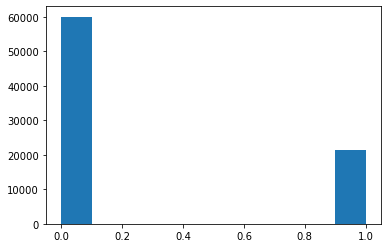

In [36]:
plt.hist(reduced_train.toxic.values)

In [41]:
train_predict = model.predict(validate_dataset)

In [42]:
train_predict.shape

(8000, 1)

(array([6770., 1230.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

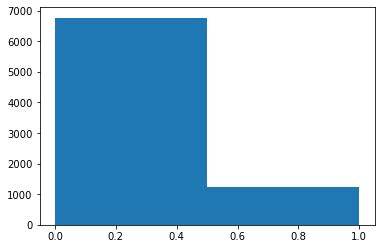

In [46]:
plt.hist(y_validate.squeeze(),bins=2)

In [45]:
np.sum(np.round(train_predict.squeeze())==y_validate)/train_predict.shape[0]

0.846625

In [ ]:
auc_metric = tf.keras.metrics.AUC(num_thresholds=200)
_ = auc_metric.update_state(y_train,train_predict.squeeze())
auc_metric.result().numpy()

In [51]:
# save model weights after training
ckpt_name = MODEL.replace('/','-') +'-'+ model.__class__.__name__
model.save_weights(CHECKPT_DIR+'\\'+ckpt_name +'\\'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#### Predict Test Data

In [ ]:
# test_predict = model.predict(test_dataset)